In [56]:
held_out = True # whether to use held out data

In [57]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as  np
import pandas as pd
import scipy.stats as stats

from decimal import Decimal

import os

import analysis_utils as utils
import supplement

In [58]:
import importlib
importlib.reload(utils)
importlib.reload(supplement)

<module 'supplement' from '/home/appreciate/Dropbox (MIT)/btc-analysis/An-Experimental-Study-of-Cryptocurrency-Market-Dynamics/supplement.py'>

# Reading Data

In [59]:
checks, interventions = utils.read_data(held_out)

155111 total confirmatory trials
620318 total confirmatory observations
217 coins
start: 2015-04-12 12:41:57
end: 2015-10-19 21:38:37
Coins traded:
 42, AC, ACOIN, AGS, ALF, ALN, AMC, ANC, APEX, ARCH, ARG, ARI, AUR, AXR, BCX, BEN, BET, BITB, BLK, BLU, BNCR, BOST, BQC, BTB, BTCD, BTE, BTG, BTM, BUK, CACH, CAIx, CANN, CAP, CASH, CAT, CBX, CCN, CIN, CINNI, CKC, CLAM, CLOAK, CLR, CMC, CNC, CNL, COMM, COOL, CRACK, CRAIG, CRC, CRYPT, CSC, DASH, DEM, DGB, DGC, DMD, DOGE, DOGED, DRKC, DSB, DT, DVC, EAC, EFL, ELC, EMC2, EMD, EXCL, EXE, EZC, FC2, FFC, FIBRE, FLT, FRAC, FRC, FRK, FST, FTC, GB, GDC, GLC, GLD, GLX, GLYPH, GML, GUE, HAL, HBN, HUC, HVC, HYP, ICB, IFC, IOC, IXC, JBS, JKC, JUDGE, KDC, KEY, KGC, LAB, LGD, LK7, LKY, LSD, LTB, LTC, LTCD, LTCX, LXC, LYC, MAX, MEC, MED, MIN, MINT, MN, MNC, MNE, MRY, MYR, MYST, MZC, NAN, NAUT, NAV, NBL, NEC, NET, NMB, NMC, NOBL, NRB, NRS, NVC, NXT, NYAN, OPAL, ORB, OSC, PHS, POT, PPC, PSEUD, PTS, PXC, PYC, QRK, RDD, RIPO, RPC, RT2, RYC, RZR, SAT2, SBC, SDC, 

In [60]:
checks = utils.expand_columns(checks, interventions)

In [61]:
daily_volume = utils.get_daily_volume(checks)

In [62]:
coin_data = utils.get_coin_data(checks)

# Supplementary Analysis

## Randomization Validity

In [63]:
mons = [0]
treats = ['buy','sell']
deps = lambda a: ['recent_last_trade_' + a,'last percent ' + a + ' BTC volume','recent_last_trade_nonnull']

ntests = 1#len(mons)*len(treats)*len(deps('buy'))

print('num tests',ntests)

print("\\begin{tabular}{|l|l|l|l|l|l|l|l|l|}")
print("\\hline")
print("Time & Cond. & Dep. Var. & $n$ Control & $n$ Treat & Ctrl Mean & Mean Effect & $t$-stat & $p$\\\\\\hline")
minutes = {0:'0',1:'15',2:'30',3:'60'}
actions = {'buy':'Buy','sell':"Sell"}
dep_vars = {'recent_last_trade_buy':'Buy Prob.',
            'recent_last_trade_sell':'Sell Prob.',
            'last percent buy BTC volume':'\% Buy Vol.',
            'last percent sell BTC volume':'\% Sell Vol.',
            'recent_last_trade_nonnull':'Trade Prob.'}
for m in mons:
    for a in treats:
        for dep in deps(a):
            x = checks.loc[(checks['condition'] == a)&(checks['monitor_num'] == m)][dep].dropna()
            y = checks.loc[(checks['condition'] == 'control')&(checks['monitor_num'] == m)][dep].dropna()
            results = stats.ttest_ind(x,y)
            print(' & '.join(map(str, [minutes[m] + ' Min.', 
                                       actions[a], 
                                       dep_vars[dep], 
                                       len(y),
                                       len(x),
                                       round(np.mean(y),3), 
                                       round(np.mean(x) - np.mean(y),3), 
                                       round(results.statistic,3), 
                                       '%.2e' % Decimal(min(ntests*results.pvalue,1))])) + '\\\\\\hline')

print('\\end{tabular}')

num tests 1
\begin{tabular}{|l|l|l|l|l|l|l|l|l|}
\hline
Time & Cond. & Dep. Var. & $n$ Control & $n$ Treat & Ctrl Mean & Mean Effect & $t$-stat & $p$\\\hline
0 Min. & Buy & Buy Prob. & 52056 & 51321 & 0.298 & -0.002 & -0.604 & 5.46e-01\\\hline
0 Min. & Buy & \% Buy Vol. & 52056 & 51321 & 0.321 & -0.001 & -0.265 & 7.91e-01\\\hline
0 Min. & Buy & Trade Prob. & 52056 & 51321 & 1.0 & 0.0 & nan & nan\\\hline
0 Min. & Sell & Sell Prob. & 52056 & 51734 & 0.702 & 0.003 & 0.935 & 3.50e-01\\\hline
0 Min. & Sell & \% Sell Vol. & 52056 & 51734 & 0.679 & 0.003 & 1.077 & 2.82e-01\\\hline
0 Min. & Sell & Trade Prob. & 52056 & 51734 & 1.0 & 0.0 & nan & nan\\\hline
\end{tabular}


In [64]:
n = sum((checks['monitor_num'] == 0)&(checks['condition'] == 'control'))
m = sum((checks['monitor_num'] == 0)&(checks['condition'] == 'buy'))
print ('Buy proportion', n, m, m/float(n))
print (stats.binom_test(m, 2*n))

n = sum((checks['monitor_num'] == 0)&(checks['condition'] == 'control'))
m = sum((checks['monitor_num'] == 0)&(checks['condition'] == 'sell'))
print ('Sell proportion', n, m, m/float(n))
print (stats.binom_test(m, 2*n))


Buy proportion 52056 51321 0.985880590134
5.29374211614e-06
Sell proportion 52056 51734 0.993814353773
0.0462844090981


In [65]:
print ("\\begin{tabular}{|l|l|l|l|l|l|l|}")
print ("\\hline")
print ("Time & Cond. & Dep. Var. & Ctrl Mean & Treat Mean & K-S $p$ \\\\")
print ("\\hline")
#print "Time & Cond. & Dep. Var. & Ctrl Mean & Treat Mean & t-test $p$ & K-S $p$ \\\\"
minutes = {0:'0',1:'15',2:'30',3:'60'}
actions = {'buy':'Buy','sell':"Sell"}

dep_vars = {'total_60':'BTC Vol.', 
            'buy_total_60':'BTC Buy Vol.',
            'sell_total_60':'BTC Sell Vol.', 
            'last_trade_price':'Last Trade Price', 
            'last_trade_total':'Last Trade BTC',
            'highest_buy_price':'Best Sell Price',
            'highest_buy_total':'Best Sell Size', 
            'lowest_sell_price':'Best Buy Price', 
            'lowest_sell_total':'Best Buy Size', 
            'spread':'Spread'}

for m in [0]:
    for a in ['buy','sell']:
        for dep in ['total_60',
                    'buy_total_60',
                    'sell_total_60', 
                    'last_trade_price', 
                    'last_trade_total',
                    'highest_buy_price',
                    'highest_buy_total', 
                    'lowest_sell_price', 
                    'lowest_sell_total', 
                    'spread']:
            x = checks.loc[(checks['condition'] == a)&(checks['monitor_num'] == m)][dep].dropna()
            y = checks.loc[(checks['condition'] == 'control')&(checks['monitor_num'] == m)][dep].dropna()
            t_results = stats.ttest_ind(x,y)
            ks_results = stats.ks_2samp(x,y)
            print (' & '.join(map(str, [minutes[m] + ' Min.', 
                                       actions[a], 
                                       dep_vars[dep], 
                                       '%.2e' % Decimal(np.mean(y)), 
                                       '%.2e' % Decimal(np.mean(x)), 
                                       '%.2e' % Decimal(ks_results.pvalue)])) + '\\\\')

print ("\\hline")
print ('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|l|}
\hline
Time & Cond. & Dep. Var. & Ctrl Mean & Treat Mean & K-S $p$ \\
\hline
0 Min. & Buy & BTC Vol. & 2.31e-01 & 2.47e-01 & 3.09e-01\\
0 Min. & Buy & BTC Buy Vol. & 1.10e-01 & 1.14e-01 & 6.73e-01\\
0 Min. & Buy & BTC Sell Vol. & 1.21e-01 & 1.33e-01 & 3.29e-01\\
0 Min. & Buy & Last Trade Price & 3.03e-02 & 2.89e-02 & 4.35e-01\\
0 Min. & Buy & Last Trade BTC & 8.05e-03 & 7.91e-03 & 9.56e-01\\
0 Min. & Buy & Best Sell Price & 3.02e-02 & 2.87e-02 & 4.32e-01\\
0 Min. & Buy & Best Sell Size & 4.84e-01 & 5.45e-01 & 2.47e-02\\
0 Min. & Buy & Best Buy Price & 3.06e-02 & 2.91e-02 & 4.64e-01\\
0 Min. & Buy & Best Buy Size & 4.18e-01 & 4.87e-01 & 8.36e-07\\
0 Min. & Buy & Spread & 3.94e-04 & 4.04e-04 & 8.79e-03\\
0 Min. & Sell & BTC Vol. & 2.31e-01 & 2.39e-01 & 5.25e-01\\
0 Min. & Sell & BTC Buy Vol. & 1.10e-01 & 1.06e-01 & 9.91e-01\\
0 Min. & Sell & BTC Sell Vol. & 1.21e-01 & 1.33e-01 & 2.87e-01\\
0 Min. & Sell & Last Trade Price & 3.03e-02 & 2.74e-02 & 5.75e-01\

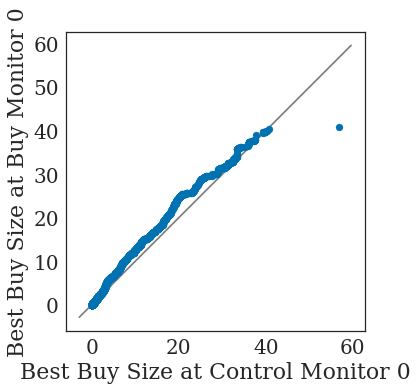

In [66]:

Control = checks.loc[(checks['monitor_num'] == 0)&(checks['condition'] == 'control'),'lowest_sell_total']
Buy = checks.loc[(checks['monitor_num'] == 0)&(checks['condition'] == 'buy'),'lowest_sell_total']

sns.set(font = 'serif', palette = 'colorblind', style = 'white', font_scale = 2)

x = sorted(Control)
y = sorted(np.percentile(Buy,100*np.array(supplement.ppoints(Control))))

fig, ax = plt.subplots()

ax.scatter(x,y)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)
ax.set_aspect('equal')

plt.xlabel('Best Buy Size at Control Monitor 0')
plt.ylabel('Best Buy Size at Buy Monitor 0')
plt.savefig('buy-control-highest_buy_total-qq.jpg', bbox_inches = 'tight')


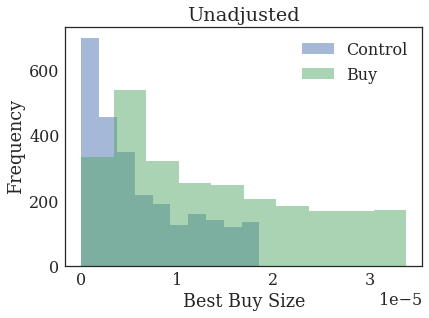

In [67]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')

Control = checks.loc[(checks['monitor_num'] == 0)&(checks['condition'] == 'control'),'lowest_sell_total']
Buy = checks.loc[(checks['monitor_num'] == 0)&(checks['condition'] == 'buy'),'lowest_sell_total']

x = sorted(Control)
y = sorted(np.percentile(Buy,100*np.array(supplement.ppoints(Control))))

x = x[:int(0.05 * len(x))]
y = y[:int(0.05 * len(y))]

plt.hist(x, bins = 10, alpha=0.5, label='Control')
plt.hist(y, bins = 10, alpha=0.5, label='Buy')
plt.legend(loc='upper right')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.title('Unadjusted')
plt.xlabel('Best Buy Size')
plt.ylabel('Frequency')
plt.savefig('lowest_sell-low-hist.jpg', bbox_inches = 'tight')



In [68]:
Control = checks.loc[(checks['monitor_num'] == 0)&(checks['condition'] == 'control'),'lowest_sell_total']

#threshold = np.percentile(Control, 100*(1 - len(Buy)/float(len(Control))))
threshold = np.percentile(Control, 2)


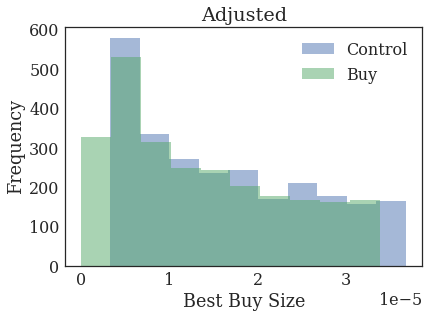

In [69]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')

Control = checks.loc[(checks['monitor_num'] == 0)&(checks['condition'] == 'control')&(checks['lowest_sell_total'] > threshold),'lowest_sell_total']
Buy = checks.loc[(checks['monitor_num'] == 0)&(checks['condition'] == 'buy'),'lowest_sell_total']

x = sorted(Control)
y = sorted(np.percentile(Buy,100*np.array(supplement.ppoints(Control))))

x = x[:int(0.05 * len(x))]
y = y[:int(0.05 * len(y))]

plt.hist(x, bins = 10, alpha=0.5, label='Control')
plt.hist(y, bins = 10, alpha=0.5, label='Buy')
plt.legend(loc='upper right')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.title('Adjusted')
plt.xlabel('Best Buy Size')
plt.ylabel('Frequency')
plt.savefig('lowest_sell-sub-low-hist.jpg', bbox_inches = 'tight')


In [70]:


print ("\\begin{tabular}{|l|l|l|l|l|l|l|}")
print ("\\hline")
#print "Time & Cond. & Dep. Var. & Ctrl Mean & Treat Mean & t-test $p$ & K-S $p$ \\\\"
print ("Time & Cond. & Dep. Var. & Ctrl Mean & Treat Mean & K-S $p$ \\\\")

minutes = {0:'0',1:'15',2:'30',3:'60'}
actions = {'buy':'Buy','sell':"Sell"}

dep_vars = {'total_60':'BTC Vol.', 
            'buy_total_60':'BTC Buy Vol.',
            'sell_total_60':'BTC Sell Vol.', 
            'last_trade_price':'Last Trade Price', 
            'last_trade_total':'Last Trade BTC',
            'highest_buy_price':'Best Buy Price',
            'highest_buy_total':'Best Buy Size', 
            'lowest_sell_price':'Best Sell Price', 
            'lowest_sell_total':'Best Sell Size', 
            'spread':'Spread'}

for m in [0]:
    for a in ['buy','sell']:
        for dep in ['total_60',
                    'buy_total_60',
                    'sell_total_60', 
                    'last_trade_price', 
                    'last_trade_total',
                    'highest_buy_price',
                    'highest_buy_total', 
                    'lowest_sell_price', 
                    'lowest_sell_total', 
                    'spread']:
            x = checks.loc[(checks['condition'] == a)&(checks['monitor_num'] == m)][dep].dropna()
            y = checks.loc[(checks['condition'] == 'control')&(checks['monitor_num'] == m)&(checks['lowest_sell_total'] > threshold)][dep].dropna()
            t_results = stats.ttest_ind(x,y)
            ks_results = stats.ks_2samp(x,y)
            print (' & '.join(map(str, [minutes[m] + ' Min.', 
                                       actions[a], 
                                       dep_vars[dep], 
                                       '%.2e' % Decimal(np.mean(y)), 
                                       '%.2e' % Decimal(np.mean(x)), 
                                       '%.2e' % Decimal(ks_results.pvalue)])) + '\\\\')

print ("\\hline")
print ('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|l|}
\hline
Time & Cond. & Dep. Var. & Ctrl Mean & Treat Mean & K-S $p$ \\
0 Min. & Buy & BTC Vol. & 2.32e-01 & 2.47e-01 & 5.88e-01\\
0 Min. & Buy & BTC Buy Vol. & 1.11e-01 & 1.14e-01 & 7.81e-01\\
0 Min. & Buy & BTC Sell Vol. & 1.22e-01 & 1.33e-01 & 5.98e-01\\
0 Min. & Buy & Last Trade Price & 3.01e-02 & 2.89e-02 & 8.30e-01\\
0 Min. & Buy & Last Trade BTC & 7.98e-03 & 7.91e-03 & 9.68e-01\\
0 Min. & Buy & Best Buy Price & 3.00e-02 & 2.87e-02 & 8.25e-01\\
0 Min. & Buy & Best Buy Size & 4.92e-01 & 5.45e-01 & 1.24e-01\\
0 Min. & Buy & Best Sell Price & 3.04e-02 & 2.91e-02 & 8.40e-01\\
0 Min. & Buy & Best Sell Size & 4.27e-01 & 4.87e-01 & 3.07e-01\\
0 Min. & Buy & Spread & 3.91e-04 & 4.04e-04 & 7.04e-02\\
0 Min. & Sell & BTC Vol. & 2.32e-01 & 2.39e-01 & 7.69e-01\\
0 Min. & Sell & BTC Buy Vol. & 1.11e-01 & 1.06e-01 & 9.99e-01\\
0 Min. & Sell & BTC Sell Vol. & 1.22e-01 & 1.33e-01 & 5.48e-01\\
0 Min. & Sell & Last Trade Price & 3.01e-02 & 2.74e-02 & 7.66e-01\\
0 Min

In [71]:
checks['first_lowest_sell_total'] = np.nan
checks.loc[checks['monitor_num'] == 0,'first_lowest_sell_total'] = checks.loc[checks['monitor_num'] == 0,'lowest_sell_total'].copy()
checks['first_lowest_sell_total'] = checks['first_lowest_sell_total'].ffill()

In [72]:
n = sum((checks['monitor_num'] == 0)&(checks['condition'] == 'control')&(checks['first_lowest_sell_total'] > threshold))

m = sum((checks['monitor_num'] == 0)&(checks['condition'] == 'buy'))
print ('Buy proportion', n, m, m/float(n))
print ('binomial p:', stats.binom_test(m, 2*n))

m = sum((checks['monitor_num'] == 0)&(checks['condition'] == 'sell'))
print ('Sell proportion', n, m, m/float(n))
print ('binomial p:', stats.binom_test(m, 2*n))

Buy proportion 51013 51321 1.00603767667
binomial p: 0.0541795137782
Sell proportion 51013 51734 1.01413365221
binomial p: 6.4388271896e-06


In [73]:
mons = [1,2,3]
treats = ['buy','sell']
deps = lambda a: ['recent_last_trade_' + a,'last percent ' + a + ' BTC volume','recent_last_trade_nonnull']

ntests = len(mons)*len(treats)*len(deps('buy'))

print('num tests',ntests)

print("\\begin{tabular}{|l|l|l|l|l|l|l|l|l|}")
print("\\hline")
print("Time & Cond. & Dep. Var. & $n$ Control & $n$ Treat & Ctrl Mean & Mean Effect & $t$-stat & $p$\\\\\\hline")

minutes = {0:'0',1:'15',2:'30',3:'60'}

actions = {'buy':'Buy','sell':"Sell"}

dep_vars = {'recent_last_trade_buy':'Buy Prob.',
            'recent_last_trade_sell':'Sell Prob.',
            'last percent buy BTC volume':'\% Buy Volume',
            'last percent sell BTC volume':'\% Sell Volume',
            'recent_last_trade_nonnull':'Trade Prob.'}

for m in mons:
    for a in treats:
        for dep in deps(a):
            x = checks.loc[(checks['condition'] == a)&(checks['monitor_num'] == m)][dep].dropna()
            y = checks.loc[(checks['condition'] == 'control')&(checks['monitor_num'] == m)&(checks['first_lowest_sell_total'] > threshold)][dep].dropna()
            results = stats.ttest_ind(x,y)
            print(' & '.join(map(str, [minutes[m] + ' Min.', 
                                       actions[a], 
                                       dep_vars[dep], 
                                       len(y),
                                       len(x),
                                       round(np.mean(y),3), 
                                       round(np.mean(x) - np.mean(y),3), 
                                       round(results.statistic,3),
                                       '%.2e' % Decimal(min(ntests*results.pvalue,1))])) + '\\\\\\hline')

print('\\end{tabular}')

num tests 18
\begin{tabular}{|l|l|l|l|l|l|l|l|l|}
\hline
Time & Cond. & Dep. Var. & $n$ Control & $n$ Treat & Ctrl Mean & Mean Effect & $t$-stat & $p$\\\hline
15 Min. & Buy & Buy Prob. & 25013 & 25602 & 0.279 & 0.019 & 4.66 & 5.70e-05\\\hline
15 Min. & Buy & \% Buy Volume & 23873 & 24313 & 0.29 & 0.017 & 4.296 & 3.14e-04\\\hline
15 Min. & Buy & Trade Prob. & 51008 & 51314 & 0.49 & 0.009 & 2.736 & 1.12e-01\\\hline
15 Min. & Sell & Sell Prob. & 25013 & 25987 & 0.721 & -0.005 & -1.324 & 1.00e+00\\\hline
15 Min. & Sell & \% Sell Volume & 23873 & 24660 & 0.71 & -0.005 & -1.227 & 1.00e+00\\\hline
15 Min. & Sell & Trade Prob. & 51008 & 51727 & 0.49 & 0.012 & 3.851 & 2.12e-03\\\hline
30 Min. & Buy & Buy Prob. & 23228 & 23871 & 0.278 & 0.004 & 0.965 & 1.00e+00\\\hline
30 Min. & Buy & \% Buy Volume & 23164 & 23802 & 0.291 & 0.005 & 1.397 & 1.00e+00\\\hline
30 Min. & Buy & Trade Prob. & 51007 & 51312 & 0.455 & 0.01 & 3.153 & 2.91e-02\\\hline
30 Min. & Sell & Sell Prob. & 23228 & 23809 & 0.722 & 0

In [74]:
remove = (checks['condition'] == 'control')&(checks['first_lowest_sell_total'] < threshold)
sub = checks.loc[~remove]

reg_features = ['coin_name','monitor_num','buy_state','sell_state','buy_eats_block', 'sell_eats_block','condition',
                    'recent_last_trade_buy','recent_last_trade_sell','recent_last_trade_nonnull','last percent buy BTC volume',
                    'last percent sell BTC volume',
                    'this_trade_total','initial_total_60','initial_last_trade_buy','initial_last_trade_sell',
                    'initial_last percent buy BTC volume','initial_last percent sell BTC volume',
                    'initial_weekday','coin_total_60']


sub[reg_features].to_csv('tmp_regression_features.csv',index = False)

os.system('Rscript regression_analysis.R > tmp')
with open('tmp') as f:
    for l in f.readlines():
        print(l)

for m in [0,1,2,3]:
    print (sum((sub['monitor_num'] == m)&(sub['condition'] == 'buy')))
    print (sum((sub['monitor_num'] == m)&(sub['condition'] == 'sell')))
    print (sum((sub['monitor_num'] == m)&(sub['condition'] == 'control')))


Number of Tests: 18 

\begin{tabular}{|r|r|r|r|r|}

\hline

\textbf{Dep. Var.} & \textbf{Independent Var.} & \textbf{Coef.} & \textbf{$t$-stat} & \textbf{$p$-value}\\

\hline

Buy Prob. & Buy Treat. & 0.016 & 4.39 & 2e-04 \\\hline

Buy Prob. & Buy Treat.*Time 2 & -0.015 & -2.83 & 8.47e-02 \\\hline

Buy Prob. & Buy Treat.*Time 3 & -0.015 & -3.07 & 3.85e-02 \\\hline

Buy Prob. & Sell Treat. & 0.003 & 0.95 & 1e+00 \\\hline

Buy Prob. & Sell Treat.*Time 2 & -0.003 & -0.53 & 1e+00 \\\hline

Buy Prob. & Sell Treat.*Time 3 & -0.003 & -0.53 & 1e+00 \\\hline

\% Buy Vol. & Buy Treat. & 0.014 & 4.1 & 7.49e-04 \\\hline

\% Buy Vol. & Buy Treat.*Time 2 & -0.012 & -2.34 & 3.48e-01 \\\hline

\% Buy Vol. & Buy Treat.*Time 3 & -0.015 & -3.25 & 2.06e-02 \\\hline

\% Buy Vol. & Sell Treat. & 0.003 & 0.96 & 1e+00 \\\hline

\% Buy Vol. & Sell Treat.*Time 2 & -0.005 & -0.93 & 1e+00 \\\hline

\% Buy Vol. & Sell Treat.*Time 3 & 0.001 & 0.24 & 1e+00 \\\hline

Trade Prob. & Buy Treat. & 0.006 & 2.28 & 4.04e-01

In [75]:
sub = checks.loc[(checks['monitor_num'] == 1)&(~checks['buy_total'].isnull())&(checks['first_lowest_sell_total'] > threshold)]
Control = sub.loc[(sub['condition'] == 'control'),'buy_total']
Buy = sub.loc[(sub['condition'] == 'buy'),'buy_total']
Sell = sub.loc[(sub['condition'] == 'sell'),'buy_total']


print (stats.mannwhitneyu(Buy, Control))

MannwhitneyuResult(statistic=1281054174.5, pvalue=5.966282318039412e-06)


In [76]:
print ('n', len(Sell), len(Control), len(Buy), len(Buy) - len(Control), (len(Buy) - len(Control))/float(len(Control)))
print ('means', np.mean(Sell), np.mean(Control), np.mean(Buy), np.mean(Buy) - np.mean(Control), (np.mean(Buy) - np.mean(Control))/np.mean(Control))
print ('raw', sum(Sell), sum(Control), sum(Buy), sum(Buy) - sum(Control), (sum(Buy) - sum(Control))/sum(Control))


n 50611 50899 50898 -1 -1.9646751409654412e-05
means 0.027408992213352877 0.02740053430872914 0.029243828639632246 0.0018432943309031058 0.06727220389698303
raw 1387.19650491 1394.65979578 1488.4523901 93.79259432 0.0672512354653


In [77]:
balance_check_coins = []

for c in sorted(set(checks['coin_name'])):
    
    n = sum((checks['coin_name'] == c)&(checks['monitor_num'] == 0)&(checks['condition'] == 'control'))
    m = sum((checks['coin_name'] == c)&(checks['monitor_num'] == 0)&(checks['condition'] == 'buy'))
    balance_check_coins += [[n,m]]


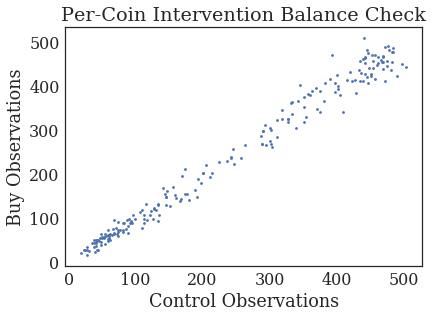

In [78]:
x = list(checks.groupby(['coin_name','monitor_num','condition'])['coin_id'].count().loc[:,0,'control'])
y = list(checks.groupby(['coin_name','monitor_num','condition'])['coin_id'].count().loc[:,0,'buy'])
plt.plot(x,y,'.')
plt.title('Per-Coin Intervention Balance Check')
plt.xlabel('Control Observations')
plt.ylabel('Buy Observations')

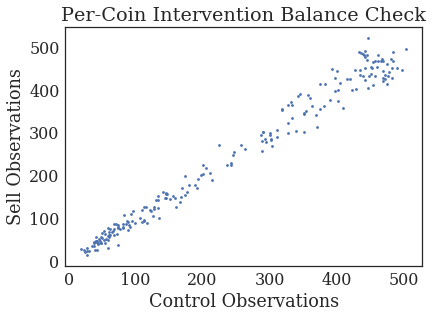

In [79]:
x = list(checks.groupby(['coin_name','monitor_num','condition'])['coin_id'].count().loc[:,0,'control'])
y = list(checks.groupby(['coin_name','monitor_num','condition'])['coin_id'].count().loc[:,0,'sell'])
plt.plot(x,y,'.')
plt.title('Per-Coin Intervention Balance Check')
plt.xlabel('Control Observations')
plt.ylabel('Sell Observations')

## Selection Bias

In [80]:
by_coin = checks.groupby(['coin_name','monitor_num'], as_index=False)

In [81]:
obs_probs = by_coin['recent_last_trade_nonnull'].mean()

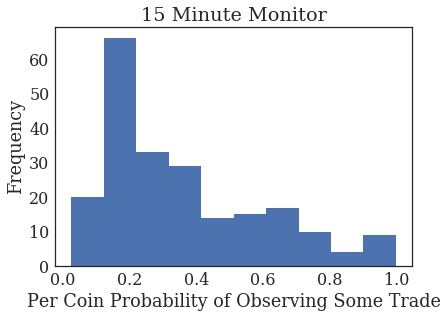

In [82]:

sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')

plt.figure()
plt.hist(np.array(obs_probs.loc[obs_probs['monitor_num'] == 1]['recent_last_trade_nonnull']))
plt.xlabel('Per Coin Probability of Observing Some Trade')
plt.ylabel('Frequency')
plt.title('15 Minute Monitor')
plt.savefig('nonnull-prob-coin-hist-15.jpg', bbox_inches = 'tight')

In [83]:
obs_nums = by_coin['recent_last_trade_buy'].count()

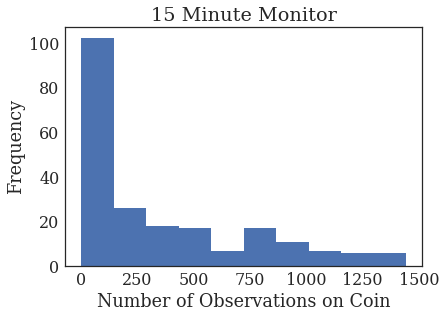

In [84]:

sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')

plt.figure()
plt.hist(np.array(obs_nums.loc[obs_nums['monitor_num'] == 1]['recent_last_trade_buy']))
plt.xlabel('Number of Observations on Coin')
plt.ylabel('Frequency')
plt.title('15 Minute Monitor')
plt.savefig('coin-obs-hist-15.jpg', bbox_inches = 'tight')

In [85]:
coin_vols = by_coin['total_60'].mean()
coin_vols = coin_vols.loc[coin_vols['monitor_num'] == 0, 'total_60']

In [86]:
x = np.log(coin_vols)
y = np.array(obs_nums.loc[obs_nums['monitor_num'] == 1]['recent_last_trade_buy'])

print (np.corrcoef(x,y))

[[ 1.         0.5816909]
 [ 0.5816909  1.       ]]


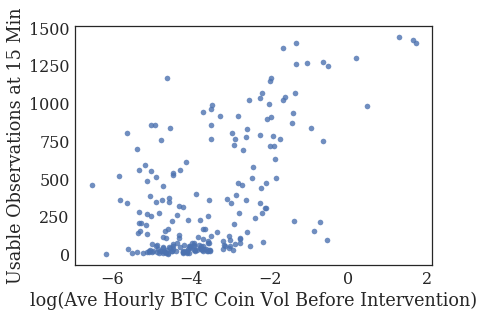

In [87]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
sns.regplot(x, y, fit_reg = False)
plt.xlabel('log(Ave Hourly BTC Coin Vol Before Intervention)')
plt.ylabel('Usable Observations at 15 Min')
plt.savefig('coin-vol-num_obs.jpg', bbox_inches = 'tight')

In [88]:
print("\\begin{tabular}{|l|l|l|l|l|l|l|l|l|}")
print("\\hline")
print("Time & Dep. Var. & $n$ Control & $n$ Treat & Ctrl Mean & Mean Effect & $t$-stat & $p$\\\\")
print("\\hline")
minutes = {0:'0',1:'15',2:'30',3:'60'}
dep_vars = {'recent_last_trade_buy':'Buy Prob.',
            'last percent buy BTC volume':'\% Buy Vol.',
            'recent_last_trade_nonnull':'Trade Prob.'}
for m in [1]:
    for dep in ['recent_last_trade_buy','last percent buy BTC volume','recent_last_trade_nonnull']:
        x = checks.loc[(checks['condition'] == 'buy')&(checks['monitor_num'] == m)][dep].dropna()
        y = checks.loc[(checks['condition'] == 'sell')&(checks['monitor_num'] == m)][dep].dropna()
        results = stats.ttest_ind(x,y)
        print(' & '.join(map(str, [minutes[m] + ' Min.', 
                                       dep_vars[dep], 
                                       len(y),
                                       len(x),
                                       round(np.mean(y),3), 
                                       round(np.mean(x) - np.mean(y),3), 
                                       round(results.statistic,3), 
                                       '%.2e' % Decimal(results.pvalue)])) + '\\\\')

print('\\hline')
print('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|l|l|l|}
\hline
Time & Dep. Var. & $n$ Control & $n$ Treat & Ctrl Mean & Mean Effect & $t$-stat & $p$\\
\hline
15 Min. & Buy Prob. & 25987 & 25602 & 0.284 & 0.013 & 3.374 & 7.42e-04\\
15 Min. & \% Buy Vol. & 24660 & 24313 & 0.295 & 0.012 & 3.1 & 1.94e-03\\
15 Min. & Trade Prob. & 51727 & 51314 & 0.502 & -0.003 & -1.11 & 2.67e-01\\
\hline
\end{tabular}


In [89]:
buy_probs = (checks.loc[checks['condition'] == 'control']).groupby(['coin_name','monitor_num'], as_index=False)['recent_last_trade_buy'].mean()

In [90]:
obs_probs = (checks.loc[checks['condition'] == 'control']).groupby(['coin_name','monitor_num'], as_index=False)['recent_last_trade_nonnull'].mean()

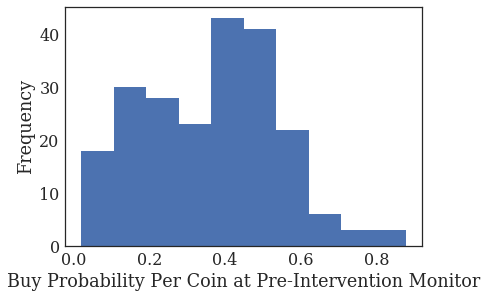

In [91]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
plt.hist(np.array(buy_probs.loc[buy_probs['monitor_num'] == 0]['recent_last_trade_buy']))
plt.xlabel('Buy Probability Per Coin at Pre-Intervention Monitor')
plt.ylabel('Frequency')
plt.savefig('buy-prob-coin-hist.jpg', bbox_inches = 'tight')

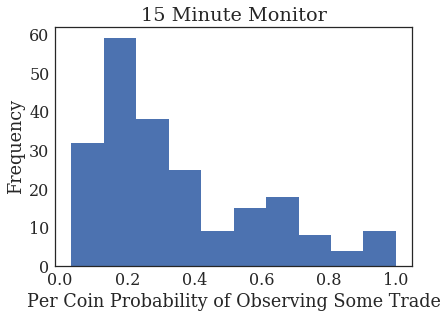

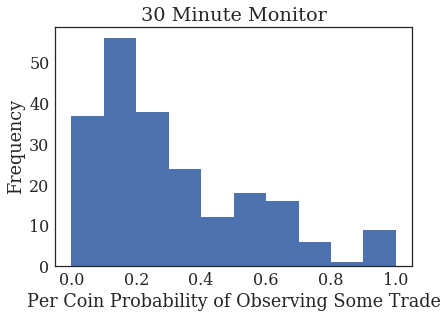

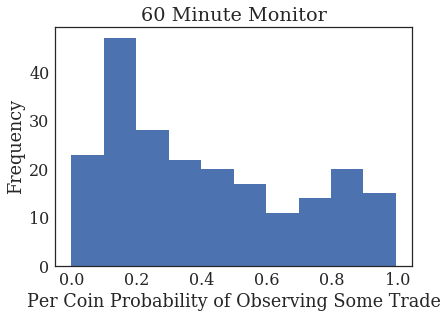

In [92]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
minutes = {1:'15',2:'30',3:'60'}
for m in [1,2,3]:
    plt.figure()
    plt.hist(np.array(obs_probs.loc[buy_probs['monitor_num'] == m]['recent_last_trade_nonnull']))
    plt.xlabel('Per Coin Probability of Observing Some Trade')
    plt.ylabel('Frequency')
    plt.title(minutes[m] + ' Minute Monitor')
    plt.savefig('nonnull-prob-coin-hist-' + minutes[m] + '.jpg', bbox_inches = 'tight')

LinregressResult(slope=-0.17425650558951167, intercept=0.39816977597113978, rvalue=-0.23667034644599697, pvalue=0.00045128816138313011, stderr=0.048901401738104505)


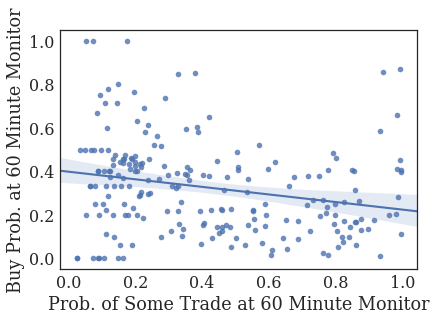

In [93]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
x = np.array(obs_probs.loc[buy_probs['monitor_num'] == 3]['recent_last_trade_nonnull'])
y = np.array(buy_probs.loc[buy_probs['monitor_num'] == 3]['recent_last_trade_buy'])
sns.regplot(x,y)
plt.xlabel('Prob. of Some Trade at 60 Minute Monitor')
plt.ylabel('Buy Prob. at 60 Minute Monitor')
plt.savefig('nonnull-prob-buy-prob-per-coin.jpg', bbox_inches = 'tight')
print(stats.linregress(x[~np.isnan(y)], y[~np.isnan(y)]))

In [94]:
reg_features = ['coin_name','monitor_num','buy_state','sell_state','buy_eats_block', 'sell_eats_block','condition',
                    'recent_last_trade_buy','recent_last_trade_sell','recent_last_trade_nonnull','last percent buy BTC volume',
                    'last percent sell BTC volume',
                    'this_trade_total','initial_total_60','initial_last_trade_buy','initial_last_trade_sell',
                    'initial_last percent buy BTC volume','initial_last percent sell BTC volume',
                    'initial_weekday','coin_total_60']

checks[reg_features].to_csv('tmp_observability.csv',index = False)

os.system('Rscript observability.R > tmp')
with open('tmp') as f:
    for l in f.readlines():
        print(l)



Call:

lm(formula = recent_last_trade_nonnull ~ buy * (buy_state + sell_state + 

    initial_last_trade_buy + initial_last.percent.buy.BTC.volume + 

    initial_total_rel), data = mdf)



Residuals:

    Min      1Q  Median      3Q     Max 

-0.8349 -0.4914  0.2561  0.4763  0.8970 



Coefficients:

                                          Estimate Std. Error t value Pr(>|t|)

(Intercept)                              0.6726359  0.0115231  58.373  < 2e-16

buy                                     -0.0145516  0.0165725  -0.878 0.379914

buy_statestay                           -0.0833879  0.0110655  -7.536 4.89e-14

buy_stateup                             -0.1394834  0.0113611 -12.277  < 2e-16

sell_statestay                           0.0636447  0.0069648   9.138  < 2e-16

sell_stateup                             0.1016740  0.0091218  11.146  < 2e-16

initial_last_trade_buy                  -0.0294045  0.0086270  -3.408 0.000654

initial_last.percent.buy.BTC.volume      0.0070313  0.0

## Heterogeneous Effects

In [95]:
checks = supplement.add_trivialness(checks, 'trivial-completed')

by_coin = checks.groupby(['coin_name','monitor_num'], as_index=False)

descriptives = by_coin['trivial',
                       'total_60',
                       'buy_total_60',
                       'sell_total_60', 
                       'last_trade_price', 
                       'last_trade_total',
                       'highest_buy_price',
                       'highest_buy_total', 
                       'lowest_sell_price', 
                       'lowest_sell_total', 
                       'spread'].median()

descriptives = descriptives[descriptives['monitor_num'] == 0]

missing coins: set()


In [96]:
by_coin = checks.groupby(['coin_name','condition','monitor_num'], as_index=False)

In [97]:
dep_var_names = ['recent_last_trade_buy','last percent buy BTC volume','recent_last_trade_nonnull']
dep_means = by_coin[dep_var_names].mean()

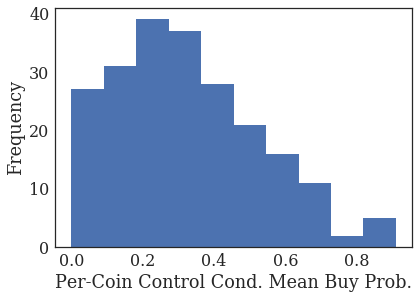

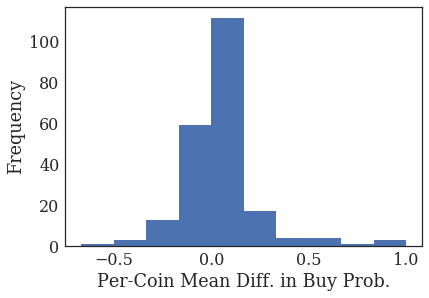

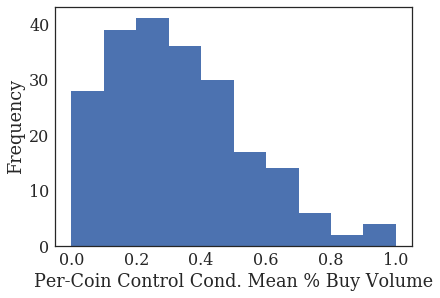

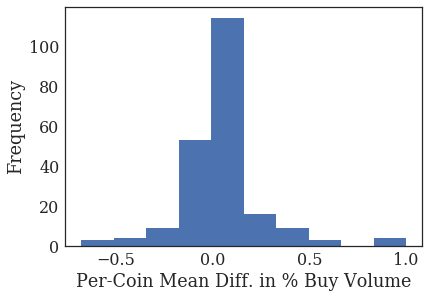

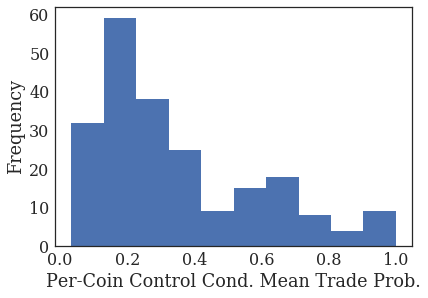

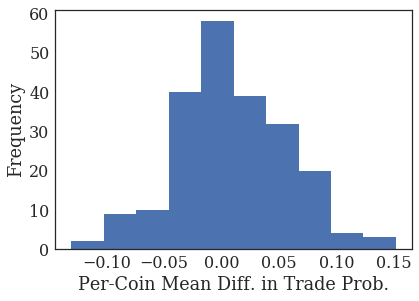

In [98]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')

minutes = {0:'0',1:'15',2:'30',3:'60'}
actions = {'buy':'Buy','sell':"Sell"}

file_names = {'recent_last_trade_buy':'buy','last percent buy BTC volume':'perc','recent_last_trade_nonnull':'null'}
dep_vars = {'recent_last_trade_buy':'Buy Prob.','last percent buy BTC volume':'% Buy Volume','recent_last_trade_nonnull':'Trade Prob.'}
for m in [1]:
    for a in ['buy']:
        for dep in ['recent_last_trade_buy','last percent buy BTC volume','recent_last_trade_nonnull']:
            x = np.array(dep_means.loc[(dep_means['monitor_num'] == m)&(dep_means['condition'] == 'control'),dep])
            y = np.array(dep_means.loc[(dep_means['monitor_num'] == m)&(dep_means['condition'] == a),dep])
            diffs = y - x
            diffs = diffs[~np.isnan(diffs)]
            plt.hist(x)
            plt.xlabel('Per-Coin Control Cond. Mean ' + dep_vars[dep])
            plt.ylabel('Frequency')
            plt.savefig(file_names[dep] + '-coin-ctrl-mean.jpg', bbox_inches = 'tight')
            plt.show()
            plt.close()
            plt.hist(diffs)
            plt.xlabel('Per-Coin Mean Diff. in ' + dep_vars[dep])
            plt.ylabel('Frequency')
            plt.savefig(file_names[dep] + '-coin-mean-diff.jpg', bbox_inches = 'tight')
            plt.show()
            plt.close()


In [99]:
x = np.array(dep_means.loc[(dep_means['monitor_num'] == 1)&(dep_means['condition'] == 'control'),dep_var_names])
y = np.array(dep_means.loc[(dep_means['monitor_num'] == 1)&(dep_means['condition'] == 'buy'),dep_var_names])
diffs = y - x

for dep in dep_var_names:
    descriptives[dep] = np.nan
descriptives[dep_var_names] = diffs

In [100]:
descriptives.to_csv('tmp_hetero_effects.csv',index = False)

In [101]:
os.system('Rscript analyze_hetero_effects.R > tmp')
with open('tmp') as f:
    for l in f.readlines():
        print(l)



Call:

lm(formula = recent_last_trade_buy ~ total_60 + buy_total_60 + 

    sell_total_60 + last_trade_price + last_trade_total + highest_buy_price + 

    highest_buy_total + lowest_sell_price + lowest_sell_total + 

    spread, data = df)



Residuals:

     Min       1Q   Median       3Q      Max 

-0.70059 -0.07482 -0.01314  0.04703  0.94840 



Coefficients:

                    Estimate Std. Error t value Pr(>|t|)   

(Intercept)        6.539e-02  2.003e-02   3.265  0.00128 **

total_60          -4.033e-02  5.550e-01  -0.073  0.94214   

buy_total_60       3.149e-01  2.772e+00   0.114  0.90968   

sell_total_60     -1.513e-01  2.762e+00  -0.055  0.95637   

last_trade_price   6.661e+02  1.625e+03   0.410  0.68237   

last_trade_total  -3.794e+01  3.267e+01  -1.161  0.24687   

highest_buy_price -3.688e+02  7.666e+02  -0.481  0.63095   

highest_buy_total -3.219e-03  4.320e-02  -0.075  0.94068   

lowest_sell_price -2.993e+02  2.094e+03  -0.143  0.88646   

lowest_sell_total -1.